# Example workflow of tools in the OpenSense software ecosystem

In [1]:
import matplotlib.pyplot as plt

import poligrain as plg
import pypwsqc
import mergeplg
import pycomlink as pycml

/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/pycomlink/io/examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Load open OpenMRG example data and project coordinates

We load 8 days of the OpenMRG dataset and do some quick visualization of the data using `poligrain`.

In [15]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [ ]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

# gauges
ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# CMLs
ds_cmls.coords["site_0_x"], ds_cmls.coords["site_0_y"] = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
ds_cmls.coords["site_1_x"], ds_cmls.coords["site_1_y"] = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Radar
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = plg.spatial.project_point_coordinates(
    ds_rad.lon, ds_rad.lat, ref_str
)

In [6]:
get_grid_at_lines = plg.spatial.GridAtLines(da_gridded_data=rad_sum, ds_line_data=ds_cmls)
radar_along_cmls = get_grid_at_lines(da_gridded_data=rad_sum)


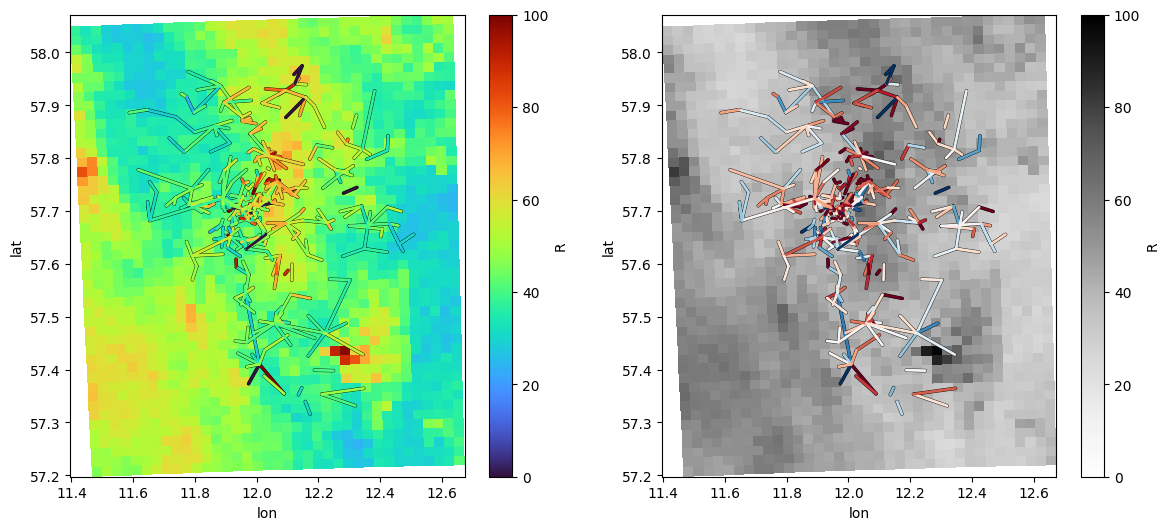

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plg.plot_map.plot_plg(
    da_grid=rad_sum,
    da_cmls=cml_sum, 
    vmin=0, 
    vmax=100,
    ax=axs[0],
)
plg.plot_map.plot_plg(
    da_grid=rad_sum,
    da_cmls=radar_along_cmls - cml_sum, 
    kwargs_cmls_plot={"vmin": -20, "vmax": 20, "cmap": "RdBu"},
    vmin=0, 
    vmax=100,
    cmap='Grays',
    ax=axs[1],
);

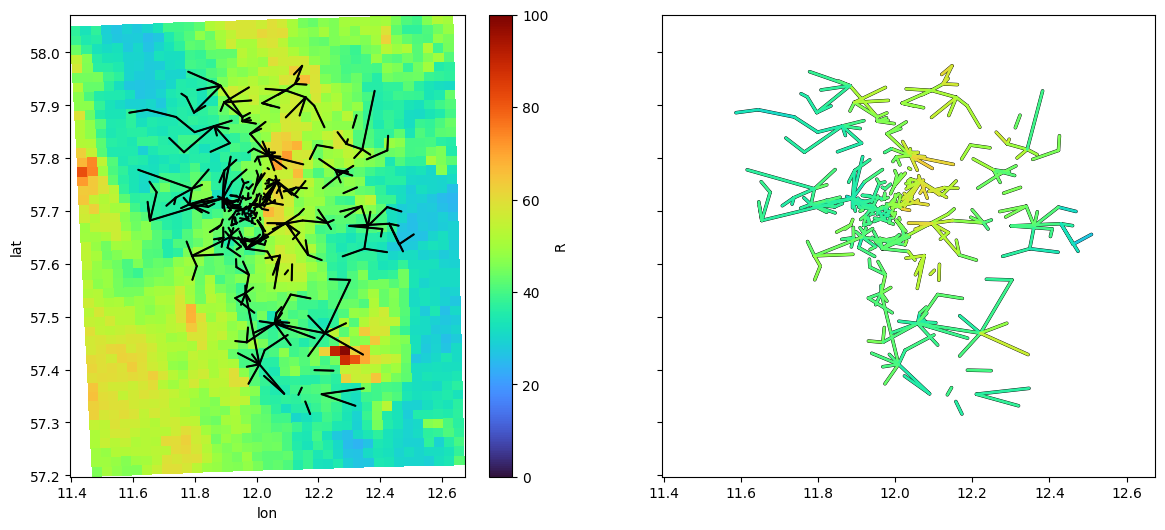

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

plg.plot_map.plot_plg(
    da_grid=rad_sum,
    da_cmls=ds_cmls, 
    vmin=0, 
    vmax=100,
    ax=axs[0],
    kwargs_cmls_plot={"line_color": 'k', "line_width": 1},
)
plg.plot_map.plot_plg(
    #da_grid=rad_sum,
    da_cmls=radar_along_cmls, 
    #kwargs_cmls_plot={"vmin": 0, "vmax": 100, "cmap": "turbo"},
    vmin=0, 
    vmax=100,
    #cmap='Grays',
    ax=axs[1],
);

## CML processing and QC based on PWS methods

In [10]:
ds_cmls

<xarray.Dataset> Size: 1GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates: (12/14)
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    ...            ...
    polarization  (sublink_id, cml_id) <U1 3kB ...
    length        (cml_id) float64 3kB ...
    site_0_x      (cml_id) float64 3kB 6.785e+05 6.776e+05 ... 6.792e+05
    site_0_y      (cml_id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x      (cml_id) float64 3kB 6.783e+05 6.77e+05 ... 6.778e+05
    site_1_y      (cml_id) float64 3kB 6.399e+06 6.402e+06 ... 6.401e+06
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB ...
    rsl           (time, sublink_id, cml_id) float64 403MB ...
    R             (sublink_id, cml_id, time) float64 403MB ...
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [11]:
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl

In [12]:
import pycomlink.processing.wet_dry.mlp as mlp

/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.5.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
import tqdm

for cml_id in tqdm.tqdm(ds_cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = ds_cmls.sel(cml_id = cml_id).isel(sublink_id = 0).tl,
        trsl_channel_2 = ds_cmls.sel(cml_id = cml_id).isel(sublink_id = 1).tl,
        model_sel = 'rad_online' # model based on radar training data, online capabilities
    )

  0%|          | 0/364 [00:00<?, ?it/s]

/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chwala-c/code/opensense_software_ecosystem_example/

In [14]:
# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad.rainfall_radar,
    ds_line_data=ds_cmls,
)

da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()
ds_cmls['wet'] = ds_cmls.wet.ffill(dim='time')

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=3,
    zeta=0.7,
    d=0.15,
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,
    f_GHz=ds_cmls.frequency / 1000,
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

AttributeError: 'Dataset' object has no attribute 'rainfall_radar'

In [5]:
rad_sum = ds_rad.R.resample(time='1h').mean().sum(dim='time')
cml_sum = ds_cmls.R.isel(sublink_id=0).resample(time='1h').mean().sum(dim='time')